In [1]:
# bridge related stats

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
df = pd.read_csv(r'../data/bridge/bridge_results.csv')

In [4]:
events = pd.read_csv(r'../data/bridge/bridge_status.csv')

In [5]:
events.iloc[0:10]

,bridge,time,event,date,text,newtime,timeobj
0,Fremont,5:09:25 PM,open,2016-01-31,The Fremont Bridge has reopened to traffic - ...,5:09:25 PM,1900-01-01 17:09:25
1,Fremont,4:59:02 PM,closed,2016-01-31,The Fremont Bridge has closed to traffic - 4...,4:59:02 PM,1900-01-01 16:59:02
2,Montlake,4:23:13 PM,open,2016-01-31,The Montlake Bridge has reopened to traffic ...,4:23:13 PM,1900-01-01 16:23:13
3,Montlake,4:17:50 PM,closed,2016-01-31,The Montlake Bridge has closed to traffic - ...,4:17:50 PM,1900-01-01 16:17:50
4,University,4:15:49 PM,open,2016-01-31,The University Bridge has reopened to traffi...,4:15:49 PM,1900-01-01 16:15:49
5,University,4:09:37 PM,closed,2016-01-31,The University Bridge has closed to traffic ...,4:09:37 PM,1900-01-01 16:09:37
6,Ballard,4:06:20 PM,open,2016-01-31,The Ballard Bridge has reopened to traffic - ...,4:06:20 PM,1900-01-01 16:06:20
7,Ballard,4:04:21 PM,closed,2016-01-31,The Ballard Bridge has closed to traffic - 4...,4:04:21 PM,1900-01-01 16:04:21
8,Fremont,3:55:26 PM,open,2016-01-30,The Fremont Bridge has reopened to traffic - ...,3:55:26 PM,1900-01-01 15:55:26
9,Fremont,3:44:55 PM,closed,2016-01-30,The Fremont Bridge has closed to traffic - 3...,3:44:55 PM,1900-01-01 15:44:55


# average closures 

In [6]:
closures = events[events['event'] == 'closed']
closures_group = closures.groupby(['date','bridge']).count()

In [7]:
closures_group['date'] = closures_group.index.get_level_values(0)
closures_group['bridge'] = closures_group.index.get_level_values(1)
# closures_group[closures_group['bridge'] == 'Ballard']

In [8]:
avg_closure_per_day = {}
for bridge in closures_group.groupby('bridge').count().index:
    avg_closure_per_day[bridge] = closures_group[closures_group['bridge'] == bridge].mean()['event']

In [9]:
df = pd.DataFrame(avg_closure_per_day, index=avg_closure_per_day.keys()).T
df = pd.DataFrame(df['Ballard'])
df.columns = ['avg_closures']
df['bridge'] = df.index
df.to_csv('../data/bridge/avg_closures.csv')

In [114]:
# Get more sophisticated later; add average closures by season, time of day, etc

# closures in current day

In [11]:
import datetime
import math
# load file created by bridge_stat.closures_per_day()
recent_df = pd.read_csv(r'../data/bridge/recent_tweets.csv')

In [12]:
recent_df['local_date'] = pd.to_datetime(recent_df['local_date'])

In [13]:
today = datetime.datetime.today()

In [14]:
tweets_today = recent_df[recent_df['local_date'].apply(lambda row:
                       (row.day == today.day) &
                       (row.month == today.month) &
                       (row.year == today.year))
   ]

In [15]:
# Get a count of tweets by bridge 
tweets_today
closures_today = tweets_today[tweets_today['event'] == 'closed']
closures_by_bridge = closures_today.groupby('bridge').count()
closures_by_bridge['bridge'] = closures_by_bridge.index
closures_by_bridge = closures_by_bridge[['bridge','event']]
closures_by_bridge.columns = ['bridge','closures_so_far']

In [16]:
# Compare to average to get anticipated remained on average
remaining_closures_df = pd.merge(closures_by_bridge, df, left_on='bridge', right_on='bridge')

# Round up for average closures
remaining_closures_df['avg_closures'] = remaining_closures_df['avg_closures'].apply(lambda row: math.ceil(row))
remaining_closures_df['closures_remaining'] = remaining_closures_df['avg_closures'] - remaining_closures_df['closures_so_far']
remaining_closures_df['%_closures_remaining'] = remaining_closures_df['closures_remaining']/remaining_closures_df['avg_closures']

In [17]:
# Leave the negatives in: indicates odds less likely 
remaining_closures_df.to_csv('../data/bridge/closure_estimate.csv')

# Average time per closing

In [18]:
from datetime import datetime, timedelta
df = pd.read_csv('../data/bridge/bridge_records.csv')

In [19]:
def set_local_time(obj, offset_hours=-7):

    #account for offset from UTC using timedelta                                
    local_timestamp = obj + timedelta(hours=offset_hours)

    return local_timestamp

In [20]:
# Load all the historical tweets and process to get columns from text, convert to local time
df['bridge'] = df['text'].map(lambda x: x.split('The ')[-1].split(' Bridge')[0])
df['created_at'] = pd.to_datetime(df['created_at'])
df['local_date'] = df['created_at'].apply(lambda x: set_local_time(x))
df['event'] = df['text'].apply(lambda x: 'closed' if ('closed' in x) else 'open')
df = df[['bridge','event', 'text','created_at', 'local_date']]

bridge_list = ['Ballard', 'Fremont', '1st Ave S', 'Montlake', 'Lower Spokane St', 'South Park', 'University']

# Select only rows with a bridge name in the bridge list
df = df[df['bridge'].isin(bridge_list)]

In [21]:
# Do some analysis

In [22]:
# # Sorting by date, should have an open, followed by close event
# fremont = fremo
# Loop through each row to extract open/close events
# each event starts with a close, and should be followed immediately by an opening, 
# otherwise error, skip until next close event
all_closures = {}

for bridge_name in df.groupby('bridge').count().index:
# for bridge_name in ['University']:
    
    bridge_closures = {}
    
    print 'calculating avg closure time for: ' + bridge_name
    
    bridge_df = df[df['bridge'] == bridge_name]

    bridge_df = bridge_df.sort_values('local_date')
    bridge_df.reset_index(inplace=True, drop=True)
    
    
    for i in xrange(len(bridge_df)-1):    # iterate to next-to-last row because we check i vs i+1
        if bridge_df.iloc[i]['event'] == 'closed':
            if bridge_df.iloc[i+1]['event'] == 'open':
                duration = bridge_df.iloc[i+1]['local_date'] - bridge_df.iloc[i]['local_date']
                bridge_closures[bridge_df.iloc[i]['local_date']] = duration
    all_closures[bridge_name] = bridge_closures

calculating avg closure time for: 1st Ave S
calculating avg closure time for: Ballard
calculating avg closure time for: Fremont
calculating avg closure time for: Lower Spokane St
calculating avg closure time for: Montlake
calculating avg closure time for: South Park
calculating avg closure time for: University


In [23]:
# Convert dictionary data in df
df_list = []
for bridge_name in df.groupby('bridge').count().index:
    print bridge_name
    dict_df = pd.DataFrame.from_dict(all_closures[bridge_name], orient='index')
    dict_df.columns = ['duration']
    dict_df['bridge'] = bridge_name
    dict_df['seconds'] = dict_df['duration'].apply(lambda row: row.seconds)
    dict_df['minutes'] = dict_df['seconds']/60.0
    dict_df['open_time'] = dict_df.index
    dict_df.reset_index(inplace=True,drop=True)
    
    df_list.append(dict_df)
    duration_df = pd.concat(df_list)

1st Ave S
Ballard
Fremont
Lower Spokane St
Montlake
South Park
University


- mean closure duration per bridge
- 95th percentile of closure duration

In [26]:
duration_df.groupby('bridge').mean()

,seconds,minutes
bridge,,
1st Ave S,606.827145,10.113786
Ballard,354.129006,5.902150
Fremont,350.067549,5.834459
Lower Spokane St,792.631313,13.210522
Montlake,307.023001,5.117050
South Park,595.762864,9.929381
University,311.010996,5.183517


In [53]:
# 
temp = pd.DataFrame([duration_df.groupby('bridge').quantile(q=0.95)['minutes'],
                     duration_df.groupby('bridge').mean()['minutes']]).T

temp.columns=['95th_percentile','mean']
temp['bridge'] = temp.index
temp.to_csv('../data/bridge/mean_95th_percentile.csv',index=False)

In [109]:
closures = pd.read_csv('../data/bridge/current_closures.csv')

In [110]:
closures = pd.merge(closures, temp,on='bridge')
from datetime import datetime

In [112]:
a = pd.to_datetime(closures['local_date_close']).iloc[0]


In [113]:
b = pd.to_datetime(closures['local_date_open']).iloc[0]

In [114]:
(a-b).seconds/60

109

In [115]:
closures['closure_time'] = pd.to_datetime(closures['local_date_close'])-pd.to_datetime(closures['local_date_open'])

In [116]:
closures['closure_time_min'] = closures['closure_time'].apply(lambda row: float(row.seconds)/60)

In [117]:
closures.ix[:,'flag'] = 0
closures.ix[closures['closure_time_min'] > closures['95th_percentile'],'flag'] = 1

In [124]:
closures[closures['bridge'] == 'University']['flag'].values[0]

1

- traffic cams

In [125]:
traffic_cams = pd.read_csv('../data/bridge/traffic_cams.csv')

In [133]:
traffic_cams[traffic_cams['Lower Spokane St'] == 'Fremont']['http://www.seattle.gov/trafficcams/images/11_Spokane.jpg'].values[0]

'http://www.seattle.gov/trafficcams/images/Westlake_Dexter.jpg?1280118223801'

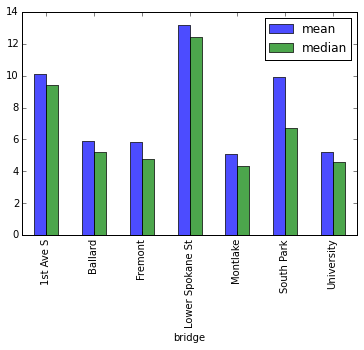

In [32]:
plotdf = pd.DataFrame([duration_df.groupby('bridge')['minutes'].mean(),
 duration_df.groupby('bridge')['minutes'].median()]).T
plotdf.columns = ['mean','median']
plotdf.plot(kind='bar', alpha=0.7)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


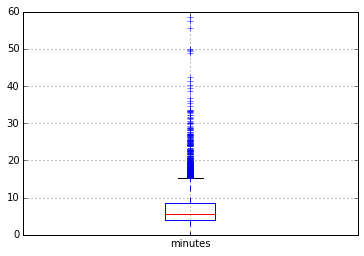

In [10]:
a = duration_df[duration_df['minutes'] < 60].boxplot(column='minutes')

In [228]:
# Shows some outliers we can remove.

# How many openings are more than 60 min?
print duration_df['minutes'].max()
print len(duration_df[duration_df['minutes'] > 90])
print len(duration_df[duration_df['minutes'] > 60])
print len(duration_df[duration_df['minutes'] > 45])
print len(duration_df[duration_df['minutes'] > 30])
print len(duration_df)

1234.31666667
3
5
12
40
10286


## Save figures to file so we can display them later

In [31]:
for bridge_name in df.groupby('bridge').count().index:
    all_bridges = duration_df[duration_df['minutes'] < 30]['minutes'].plot.hist(bins=40, alpha=0.7, normed=1)
    temp_bridge = duration_df[duration_df['bridge'] == bridge_name]
    one_bridge = temp_bridge[temp_bridge['minutes'] < 30]['minutes'].plot.hist(bins=40, alpha=0.7, normed=1)
    all_bridges.legend(['All',bridge_name])
    fig = all_bridges.get_figure()

    fig.savefig(r'../data/bridge/' + bridge_name + '.png')
    plt.clf()    # clear the plot space 

## Show distribution as subplots

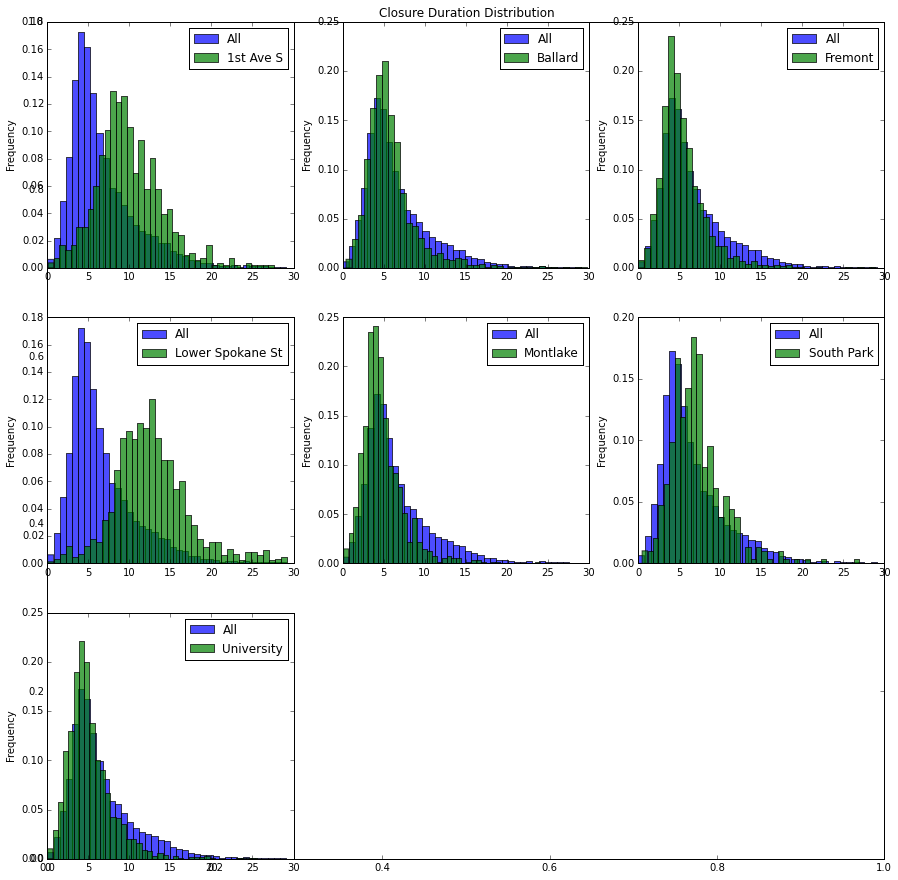

In [30]:
fig1 = plt.figure(figsize=(15,15), )
plt.title('Closure Duration Distribution')
chrt = 0
for bridge_name in df.groupby('bridge').count().index:
    chrt += 1
    ax = fig1.add_subplot(3,3,chrt)
    all_bridges = duration_df[duration_df['minutes'] < 30]['minutes'].plot.hist(bins=40, alpha=0.7, normed=1, ax=ax)
    temp_bridge = duration_df[duration_df['bridge'] == bridge_name]
    one_bridge = temp_bridge[temp_bridge['minutes'] < 30]['minutes'].plot.hist(bins=40, alpha=0.7, normed=1, ax=ax)
    all_bridges.legend(['All',bridge_name])
    

In [348]:
# Next steps:
# save this as figs and store for use in the dashboard

/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


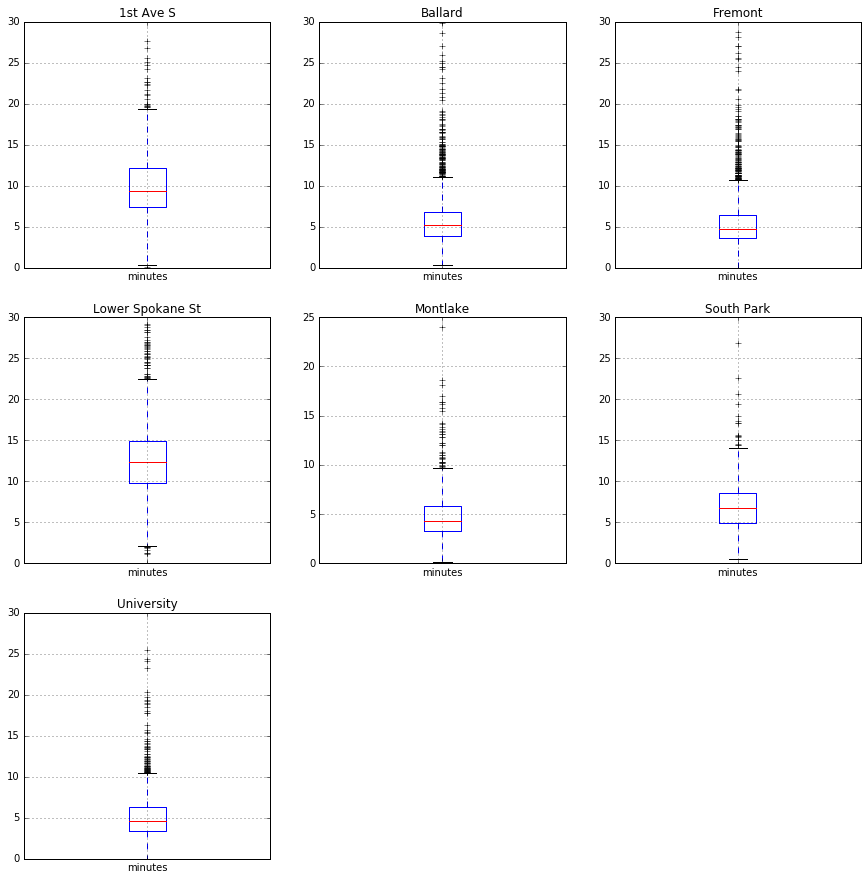

In [362]:
fig1 = plt.figure(figsize=(15,15), )
chrt = 0
for bridge_name in df.groupby('bridge').count().index:
    chrt += 1
    ax = fig1.add_subplot(3,3,chrt)
    temp_bridge = duration_df[duration_df['bridge'] == bridge_name]
    one_bridge = temp_bridge[temp_bridge['minutes'] < 30].boxplot(column='minutes')
    ax.set_title(bridge_name)

## openings by time of day

In [104]:
df['hour'] = df['local_date'].apply(lambda row: row.hour)
df['month'] = df['local_date'].apply(lambda row: row.month)

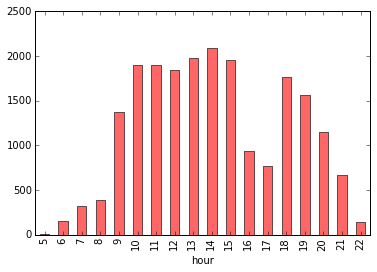

In [93]:
df.groupby('hour').count()['event'].plot(kind='bar', alpha=0.6, color='red')

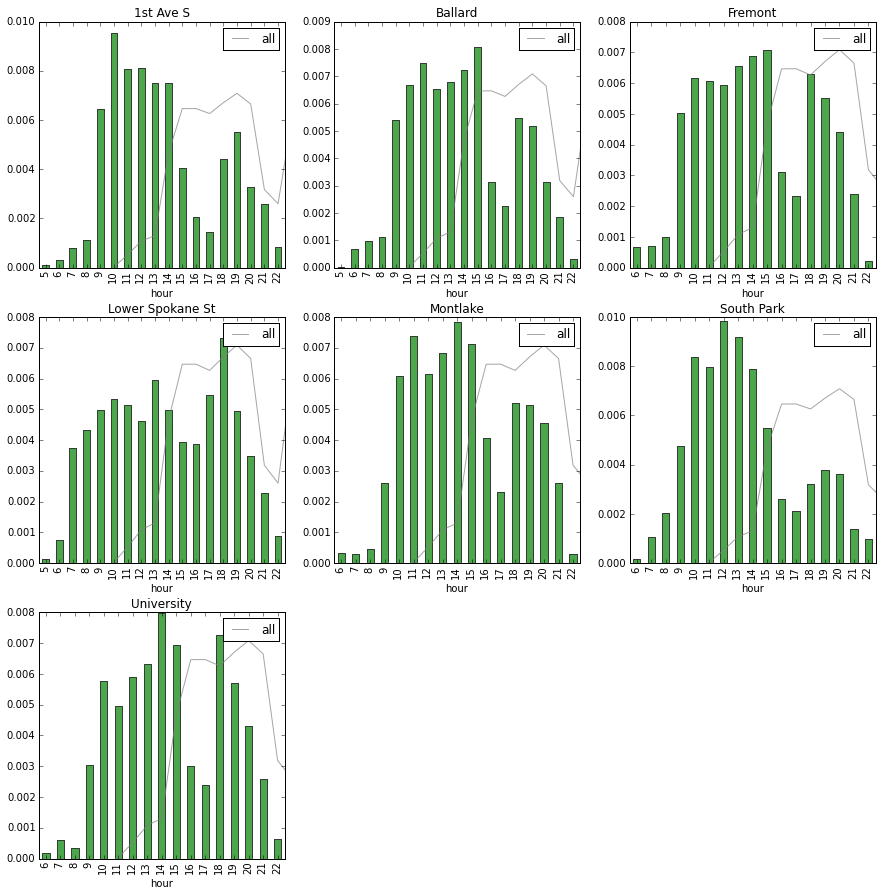

In [94]:
fig1 = plt.figure(figsize=(15,15), )

chrt = 0
for bridge_name in df.groupby('bridge').count().index:
    chrt += 1
    ax = fig1.add_subplot(3,3,chrt)
    all_bridges = ((df.groupby('hour').count()['event'])/(df['hour'].sum())).plot(alpha=0.7, color='grey')
    one_bridge = ((df[df['bridge'] == bridge_name].groupby('hour').count())/(df[df['bridge'] == bridge_name].sum()['hour']))['event'] \
    .plot(kind='bar', alpha=0.7, color='green')
    ax.set_title(bridge_name)
    all_bridges.legend(['all'])

split bridges into ship canal versus duwamish

In [98]:
duration_df.head()

,duration,bridge,seconds,minutes,open_time
0,00:10:12,1st Ave S,612,10.200000,2015-12-04 10:06:29
1,00:07:06,1st Ave S,426,7.100000,2015-11-09 20:54:33
2,00:06:56,1st Ave S,416,6.933333,2015-12-04 13:28:03
3,00:14:46,1st Ave S,886,14.766667,2016-02-22 11:25:16
4,00:22:26,1st Ave S,1346,22.433333,2016-04-11 14:41:35


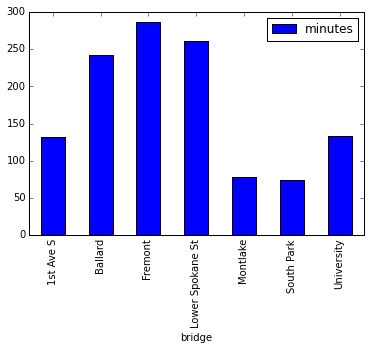

In [102]:
pd.DataFrame(duration_df.groupby('bridge').sum()['minutes']/60).plot(kind='bar')

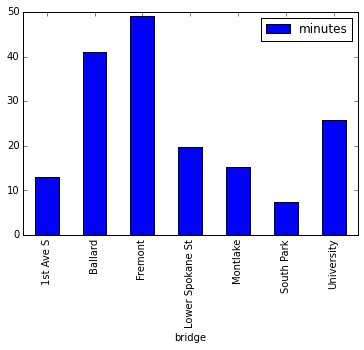

In [103]:
pd.DataFrame(duration_df.groupby('bridge').count()['minutes']/60).plot(kind='bar')

# openings by month

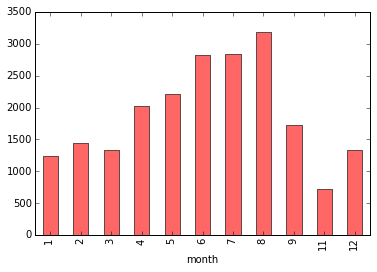

In [105]:
df.groupby('month').count()['event'].plot(kind='bar', alpha=0.6, color='red')

- morning comparisons between ship canal and duwamish bridges
- time spent open vs number of openings
- how many minutes were open vs closed for each hour, esp. during commute time
- load VMT data and calculate delay based on average volumes (or real count data)
- load bike count data and calculate bike delay 

In [3]:
import pandas as pd
df = pd.read_csv('../data/bridge/avg_closures.csv')

In [6]:
df[df['bridge'] == 'Ballard']

,Unnamed: 0,avg_closures,bridge
1,Ballard,6.670103,Ballard


In [15]:
df = pd.read_csv(r'../data/bridge/closures_per_day.csv')

In [23]:
mydict = df.to_dict()

In [ ]:
{% for key, value in resp.closures_remaining.items() %}
    {% for items in value %}
    <table>
      <tr><td>  {{ items }}

In [33]:
for key, value in mydict.items():
    print key
    print value

bridge
{0: '1st Ave S', 1: 'Ballard', 2: 'Fremont', 3: 'Lower Spokane St', 4: 'Montlake', 5: 'South Park', 6: 'University'}
Unnamed: 0
{0: '1st Ave S', 1: 'Ballard', 2: 'Fremont', 3: 'Lower Spokane St', 4: 'Montlake', 5: 'South Park', 6: 'University'}
closures_remaining
{0: 1.0, 1: -2.0, 2: -2.0, 3: 3.0, 4: 0.0, 5: 2.0, 6: -2.0}
closures_so_far
{0: 2, 1: 9, 2: 11, 3: 1, 4: 4, 5: 1, 6: 8}
avg_closures
{0: 3.0, 1: 7.0, 2: 9.0, 3: 4.0, 4: 4.0, 5: 3.0, 6: 6.0}
%_closures_remaining
{0: 0.33333333333299997, 1: -0.28571428571400004, 2: -0.222222222222, 3: 0.75, 4: 0.0, 5: 0.66666666666700003, 6: -0.33333333333299997}


In [38]:
for k, v in mydict['avg_closures'].items():
    print v

3.0
7.0
9.0
4.0
4.0
3.0
6.0
